In [10]:
import parser
from pprint import pprint

from IPython.display import Image, display
from lark import Lark, Transformer
from lark import tree as larkTree
from lark.indenter import Indenter

import os

NOTES_FOLDER = './note_files/'
NOTE_PATHS = [x for x in os.listdir(NOTES_FOLDER) if x.endswith('.md')]

def display_tree(t, filename='viz.png'):
    larkTree.pydot__tree_to_png(t, filename)
    display(Image(filename))
    os.remove(filename)

Example2


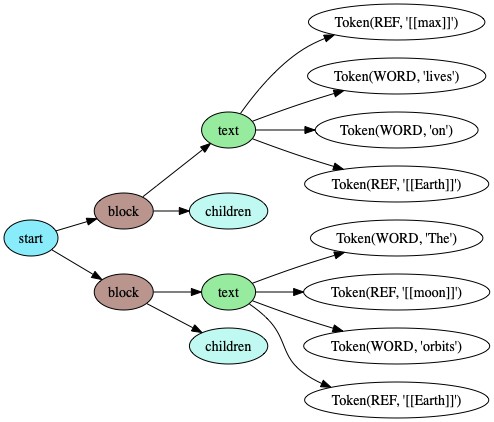

[{'children': [],
  'text': [Token(REF, '[[max]]'),
           Token(WORD, 'lives'),
           Token(WORD, 'on'),
           Token(REF, '[[Earth]]')]},
 {'children': [],
  'text': [Token(WORD, 'The'),
           Token(REF, '[[moon]]'),
           Token(WORD, 'orbits'),
           Token(REF, '[[Earth]]')]}]
Example1


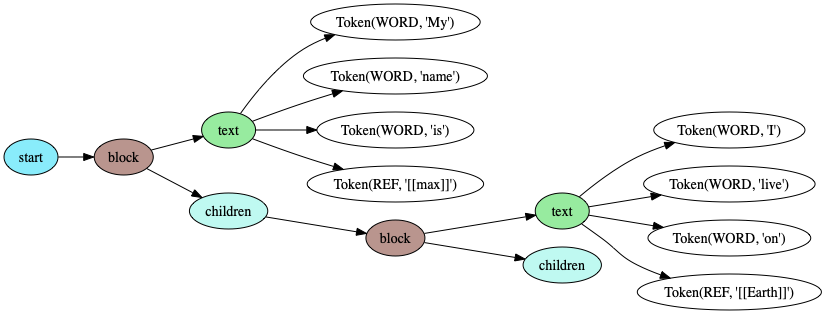

[{'children': [{'children': [],
                'text': [Token(WORD, 'I'),
                         Token(WORD, 'live'),
                         Token(WORD, 'on'),
                         Token(REF, '[[Earth]]')]}],
  'text': [Token(WORD, 'My'),
           Token(WORD, 'name'),
           Token(WORD, 'is'),
           Token(REF, '[[max]]')]}]


In [11]:
for path in NOTE_PATHS:
    note_title = path.replace('.md', '')
    note_tree = parser.parse_note_tree(NOTES_FOLDER + path)
    print(note_title)
    display_tree(note_tree)
    pprint(parser.parse_blocks(note_tree.children))